<a href="https://colab.research.google.com/github/YuHsin-Chen1221/NeuroAI-Summer-School-25/blob/main/LSM_NARMA10_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0: Setup

In [1]:

#@title Installing required packages
import sys, subprocess

def pip_install(pkg):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg], check=False)

pip_install("brian2>=2.6")
pip_install("scikit-learn>=1.3")

import numpy as np
import matplotlib.pyplot as plt
import brian2 as b2
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from brian2 import *

print("Ready. Brian2 version:", b2.__version__)


Ready. Brian2 version: 2.9.0


## 1: NARMA-10 data generator

Data length after warmup: 6900


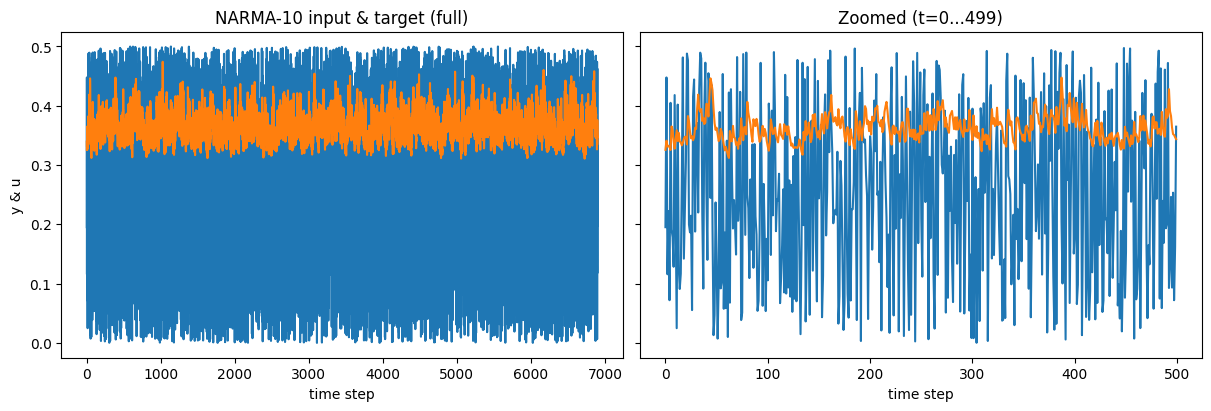

[as-is] NRMSE(u,y) = 7.3367 | corr(u,y) = 0.0106


In [2]:

#@title Generate NARMA-10 dataset
def generate_narma10(T=6000, warmup=100, rng_seed=1):
    rng = np.random.default_rng(rng_seed)
    u = rng.uniform(0.0, 0.5, size=T)
    y = np.zeros(T)
    for t in range(10, T-1):
        y[t+1] = (0.6*y[t]
                  + 0.02*y[t]*np.sum(y[t-9:t+1])
                  + 0.3*u[t-9]*u[t]
                  + 0.1)
 #       y[t+1] = (0.6*y[t]
 #                 + 0.03*y[t]*np.sum(y[t-9:t+1])
 #                 + 0.3*u[t]
 #                 - 0.0)
    return u[warmup:], y[warmup:]

T = 7000
u, y = generate_narma10(T=T, warmup=100, rng_seed=10)
print("Data length after warmup:", len(u))



# Side-by-side: full series (left) and zoomed view (right)
t0, t1 = 0, 500
t1 = min(t1, len(y))  # guard

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True, constrained_layout=True)

# Left: full
axes[0].plot(u, label="NARMA-10 input")
axes[0].plot(y, label="NARMA-10 target")
axes[0].set_title("NARMA-10 input & target (full)")
axes[0].set_xlabel("time step")
axes[0].set_ylabel("y & u")

# Right: zoomed
axes[1].plot(np.arange(t0, t1), u[t0:t1], label="NARMA-10 input")
axes[1].plot(np.arange(t0, t1), y[t0:t1], label="NARMA-10 target")
axes[1].set_title(f"Zoomed (t={t0}...{t1-1})")
axes[1].set_xlabel("time step")

plt.show()


# --- Input vs Target: NRMSE & correlation ---
# 1) 直接以同一時間索引比較（as-is）
rmse = np.sqrt(np.mean((y - u)**2))
nrmse = rmse / (np.std(y) + 1e-8)
corr = np.corrcoef(u, y)[0, 1]
print(f"[as-is] NRMSE(u,y) = {nrmse:.4f} | corr(u,y) = {corr:.4f}")



## 2: Input encodings -- Turning continous values into spike trains

Encoding: multi_channel | channels=100 | length=6900 steps
Generated 259875 spikes | auto_scale(in)=0.032 | removed collisions=0


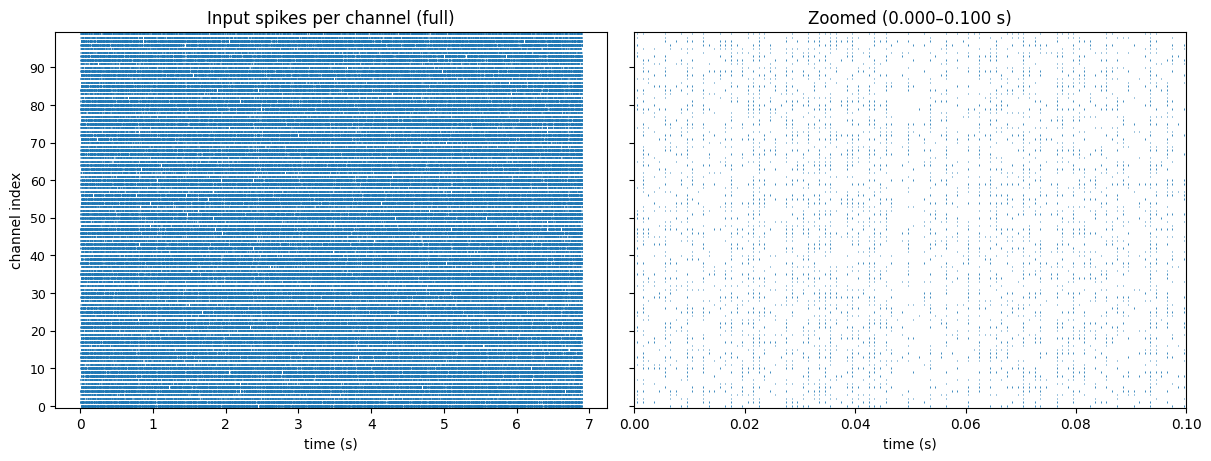

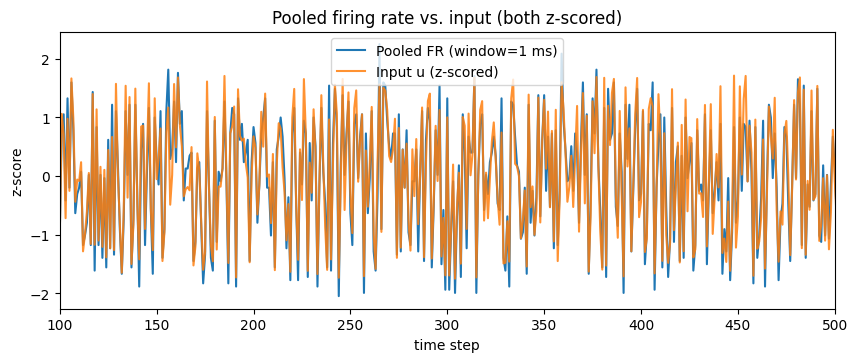

corr(z_fr, z_u) = 0.9609177261700328
NRMSE (z-scored FR vs. z-scored input) = 0.2796


In [3]:

#@title Build input spikes
# --- Global simulation/encoding knobs ---
ENCODING = "multi_channel"
dt_ms    = 1.0              # simulation time step in ms
# Hz per unit input (strong drive)
rate_scale = 2000  #@param {type:"slider", min:100, max:3000, step:100}
 # baseline Hz
rate_bias  = 10  #@param {type:"slider", min: 0, max: 100, step:1}
# Multi-channel setting
K_channels = 100             # number of parallel Poisson channels (A)
# Time-window setting
W_window   = 10             # micro-steps per original sample (B)

dt = dt_ms*ms

def _dedup_same_bin(indices, times_ms, channels, dt_ms):
    """
    Ensure at most one spike per (channel, dt-bin). If collisions occur (rare),
    keep the first and move time to the bin center (t_bin + 0.5*dt).
    Returns sorted arrays by (time, index).
    """
    if len(times_ms) == 0:
        return indices, times_ms, 0
    bins = np.floor((times_ms + 1e-12) / dt_ms).astype(np.int64)
    seen = set()
    keep_idx = []
    removed = 0
    for i, (idx, b) in enumerate(zip(indices, bins)):
        key = (int(idx), int(b))
        if key in seen:
            removed += 1
            continue
        seen.add(key)
        keep_idx.append(i)
    indices = np.array(indices)[keep_idx].astype(int, copy=False)
    bins = bins[keep_idx]
    times_ms = (bins.astype(float) + 0.5) * dt_ms
    order = np.lexsort((indices, times_ms))
    return indices[order], times_ms[order], removed

def build_input_encoding(u, y, encoding="multi_channel", K=50, W=1,
                         dt_ms=1.0, rate_scale=800.0, rate_bias=20.0, rng_seed=0):
    rng = np.random.default_rng(rng_seed)
    if encoding == "time_window":
        assert W >= 1
        u_used = np.repeat(u, W)
        y_used = np.repeat(y, W)
        channels = 1
    elif encoding == "multi_channel":
        u_used = u
        y_used = y
        channels = K
    else:
        raise ValueError("encoding must be 'multi_channel' or 'time_window'")

    Tsteps = len(u_used)
    indices = []
    times_ms = []
    t_ms = 0.0
    for t in range(Tsteps):
        lam = (rate_scale * float(u_used[t]) + rate_bias) * (dt_ms/1000.0)
        p = 1.0 - np.exp(-lam)
        if encoding == "multi_channel":
            rand = rng.random(channels)
            fire = np.nonzero(rand < p)[0]
            if len(fire) > 0:
                jitter = rng.uniform(0.0, dt_ms, size=len(fire))
                indices.extend(fire.tolist())
                times_ms.extend((t_ms + jitter).tolist())
        else:
            if rng.random() < p:
                times_ms.append(t_ms + rng.uniform(0.0, dt_ms))
                indices.append(0)
        t_ms += dt_ms

    indices = np.array(indices, dtype=int)
    times_ms = np.array(times_ms, dtype=float)

    indices, times_ms, removed = _dedup_same_bin(indices, times_ms, channels, dt_ms)

    auto_scale = 1.0/np.sqrt(max(1, channels)*max(1, W))

    return {
        "u_used": u_used,
        "y_used": y_used,
        "indices": indices,
        "times_ms": times_ms,
        "channels": channels,
        "auto_scale": auto_scale,
        "removed_collisions": removed
    }

enc = build_input_encoding(u, y, encoding=ENCODING, K=K_channels, W=W_window,
                           dt_ms=dt_ms, rate_scale=rate_scale, rate_bias=rate_bias, rng_seed=123)

print(f"Encoding: {ENCODING} | channels={enc['channels']} | length={len(enc['u_used'])} steps")
print(f"Generated {len(enc['times_ms'])} spikes | auto_scale(in)={enc['auto_scale']:.3f} | removed collisions={enc['removed_collisions']}")

# Side-by-side event plots (per channel) — shorter rasters + sparse y-ticks
t0_s, t1_s = 0.0, 0.1  # zoom window in seconds
times_s = enc["times_ms"] / 1000.0
idx = enc["indices"]
K = enc["channels"]

# Only plot the first M channels. M=100 by default
M = min(K, 100)
ch_ids = np.arange(M)

# Set array for two plots: full and zoom-in
spk_full = [times_s[idx == k] for k in ch_ids]
spk_zoom = [times_s[(idx == k) & (times_s >= t0_s) & (times_s < t1_s)] for k in ch_ids]

# Height of the figure
fig_h = 4.5  # Good range: 3.5~6
fig, axes = plt.subplots(1, 2, figsize=(12, fig_h), constrained_layout=True, sharey=True)

# Set the length of each raster
raster_len = 0.4
lw = 0.6

# Left figure: full
axes[0].eventplot(spk_full, lineoffsets=ch_ids, linelengths=raster_len, linewidths=lw)
axes[0].set_title("Input spikes per channel (full)")
axes[0].set_xlabel("time (s)")
axes[0].set_ylabel("channel index")
axes[0].set_ylim(-0.5, M - 0.5)

# Right figure: zoom-in
axes[1].eventplot(spk_zoom, lineoffsets=ch_ids, linelengths=raster_len, linewidths=lw)
axes[1].set_title(f"Zoomed ({t0_s:.3f}–{t1_s:.3f} s)")
axes[1].set_xlabel("time (s)")
axes[1].set_ylim(-0.5, M - 0.5)
axes[1].set_xlim(t0_s, t1_s)

# set labels for y axis
max_labels = 10
step = max(1, M // max_labels)
yticks = ch_ids[::step]
axes[0].set_yticks(yticks)
axes[1].set_yticks(yticks)
axes[0].tick_params(axis='y', labelsize=9)
axes[1].tick_params(axis='y', labelsize=9)

plt.show()


# === Pooled firing rate (20 ms window) vs. input signal (both z-scored) ===
WINDOW_MS = 1.0
dt_s = dt_ms / 1000.0
Tsteps = len(enc["u_used"])
channels = enc["channels"]

# 1) 將所有 channel 的 spikes 落在各 time bin 的總數（pool across channels）
if len(enc["times_ms"]) > 0:
    bins = np.floor(enc["times_ms"] / dt_ms).astype(int)
    counts = np.bincount(bins, minlength=Tsteps)   # shape (Tsteps,), 每 bin 的總 spike 數
else:
    counts = np.zeros(Tsteps, dtype=int)

# 2) 20 ms 滑動和（same 模式），換算成「每神經元、每秒」的 firing rate（Hz/neuron）
W = max(1, int(round(WINDOW_MS / dt_ms)))          # 視窗長度（以 time steps 計）
win = np.ones(W, dtype=float)
spikes_in_window = np.convolve(counts, win, mode='same')
fr_pool = spikes_in_window / (channels * (W * dt_s))  # Hz/neuron

# 3) 與輸入對齊：各自 z-score 後疊圖
def zscore(x):
    x = np.asarray(x, dtype=float)
    return (x - x.mean()) / (x.std() + 1e-8)

z_fr = zscore(fr_pool)
z_u  = zscore(enc["u_used"])

# 4) 畫圖（可選擇加上縮放視窗）
fig, ax = plt.subplots(figsize=(10, 3.6))
ax.plot(z_fr, label=f"Pooled FR (window={WINDOW_MS:.0f} ms)")
ax.plot(z_u,  label="Input u (z-scored)", alpha=0.85)
ax.set_title("Pooled firing rate vs. input (both z-scored)")
ax.set_xlabel("time step"); ax.set_ylabel("z-score")
ax.set_xlim(100, 500)
ax.legend()
plt.show()

# （可選）看看兩者的相關係數
print("corr(z_fr, z_u) =", float(np.corrcoef(z_fr, z_u)[0, 1]))

# === RMSE between the two z-scored signals ===
nrmse_z = np.sqrt(np.mean((z_fr - z_u)**2))/(np.std(z_u) + 1e-8)
print(f"NRMSE (z-scored FR vs. z-scored input) = {nrmse_z:.4f}")


## 3: Reservoir (LIF) — uses input size K (or 1)

# **2025 NeuroAI Summer School**
# Liquid state machine on NARMA-10



[Recurrent] |w| mean: E=0.473 mV, I=1.136 mV | ratio |I|/|E|=2.40


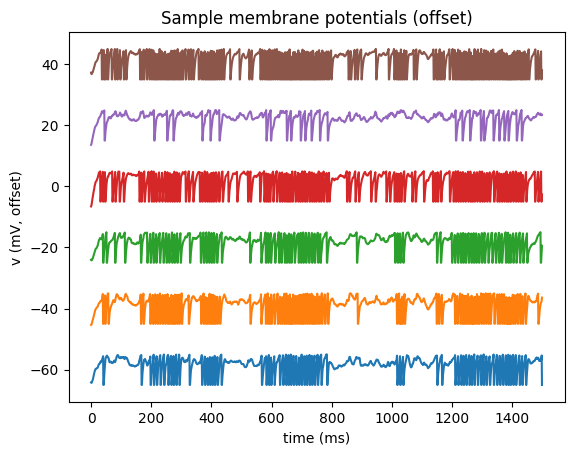

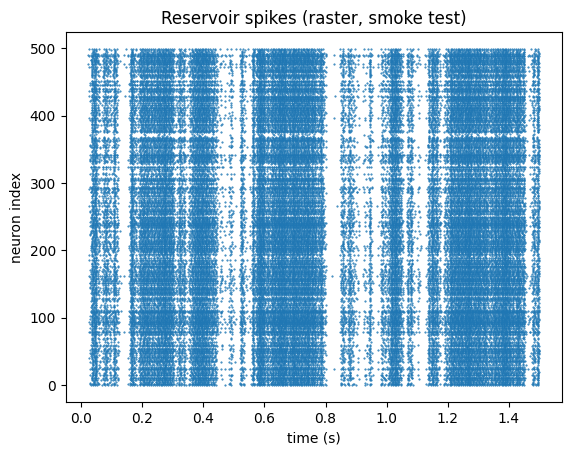

Reservoir spikes: 50993 | Mean rate (Hz/neuron): 67.99066666666667


In [107]:

#@title Define and simulate the reservoir
#@title Define and simulate the reservoir (with E/I weight controls)
def build_and_run_reservoir(u_used, indices, times_ms, input_channels,
                            g=1.2, tau_m_ms=20.0, tau_syn_ms=10.0,
                            N=300, p_rec=0.1, p_in=0.25, exc_frac=0.8,
                            w_in_scale=6.0, w_rec_scale=2.0,
                            w_rec_exc_scale=1.0,   # excitatory recurrent weight multiplier
                            w_rec_inh_scale=1.0,   # inhibitory recurrent weight multiplier
                            in_auto_scale=1.0,
                            dt_ms=1.0, rng_seed=7, record_sample=8, add_bg=True):
    start_scope()
    defaultclock.dt = dt_ms*ms
    rng = np.random.default_rng(rng_seed)

    eqs = """
    dv/dt = (-(v - v_rest) + I_syn) / tau_m : volt (unless refractory)
    dI_syn/dt = -I_syn / tau_syn : volt
    """
    v_rest = -65.0*mV
    v_reset = -65.0*mV
    v_th   = -55.0*mV
    tau_m  = tau_m_ms*ms
    tau_syn = tau_syn_ms*ms
    refrac = 2.0*ms

    Ne = int(N * exc_frac)
    G = NeuronGroup(N, eqs, threshold='v>v_th', reset='v=v_reset', refractory=refrac, method='euler')
    G.v = v_rest + (rng.random(N) * 5.0 - 2.5) * mV

    # E/I 標籤
    is_exc = np.zeros(N, dtype=bool); is_exc[:Ne] = True; rng.shuffle(is_exc)

    # ----- Recurrent synapses -----
    S = Synapses(G, G, model='w : volt', on_pre='I_syn += w', method='euler')
    S.connect(p=p_rec)

    # 基礎隨機強度（正值），之後再乘上 ± 號與 E/I 倍率
    w_base = np.clip(np.abs(rng.standard_normal(S.N)) * 0.5 + 0.7, 0.2, 2.5)

    # 依「pre 是 E or I」決定符號與倍率
    pre_is_exc = is_exc[S.i[:]]                      # True=E, False=I
    signs = np.where(pre_is_exc, 1.0, -1.0)          # E:+, I:-
    ei_mult = np.where(pre_is_exc, w_rec_exc_scale, w_rec_inh_scale)

    # 實際 recurrent 權重
    S.w = (g * w_rec_scale * ei_mult * signs * w_base * 0.5) * mV

    # （可選）列印 E/I 權重的統計，方便檢查平衡
    abs_w = np.abs(S.w[:] / mV)
    print(f"[Recurrent] |w| mean: E={abs_w[pre_is_exc].mean():.3f} mV, "
          f"I={abs_w[~pre_is_exc].mean():.3f} mV "
          f"| ratio |I|/|E|={abs_w[~pre_is_exc].mean()/(abs_w[pre_is_exc].mean()+1e-12):.2f}")

    # ----- Input synapses -----
    if len(indices) == 0:
        indices = np.array([0], dtype=int)
        times_ms = np.array([0.0], dtype=float)
    P = SpikeGeneratorGroup(input_channels, indices=indices, times=times_ms*ms)

    Sin = Synapses(P, G, model='w_in : volt', on_pre='I_syn += w_in', method='euler')
    Sin.connect(p=p_in)
    Sin.w_in = (w_in_scale * in_auto_scale * np.abs(rng.standard_normal(Sin.N)) * 1.0) * mV

    # 背景噪音（可調低或關掉以更敏感地看到 E/I 影響）
    if add_bg:
        bg = PoissonInput(target=G, target_var='I_syn', N=40, rate=5*Hz, weight=0.03*mV)

    sp_mon = SpikeMonitor(G)
    subset_idx = rng.choice(N, size=min(record_sample, N), replace=False)
    st_mon = StateMonitor(G, ["v", "I_syn"], record=subset_idx)

    run(len(u_used) * dt_ms * ms, report=None)

    return G, sp_mon, st_mon, subset_idx

win=1.42 #@param {type: "slider", min: 0.0, max: 5.0, step: 0.01}
wrec=0.58 #@param {type: "slider", min: 0.0, max:3.0, step:0.01}

# E/I balance
# excitatory multiplier
wE = 1    #@param {type: "slider", min: 0.0, max: 3.0, step: 0.05}
# inhibitory multiplier
wI = 2.4    #@param {type: "slider", min: 0.0, max: 3.0, step: 0.05}

# Synaptic time constant
tau_synapse = 7.1 #@param {type: "slider", min: 1.0, max: 20.0, step: 0.1}

# Smoke test
limit = min(1500, len(enc["u_used"]))
sub_mask = enc["times_ms"] < (limit * 1.0)  # ms
G_test, sp_mon_test, st_mon_test, idx_test = build_and_run_reservoir(
    enc["u_used"][:limit],
    enc["indices"][sub_mask],
    enc["times_ms"][sub_mask],
    enc["channels"],
    g=1.2, tau_m_ms=6.0, tau_syn_ms=tau_synapse,
    N=500, p_rec=0.1, p_in=0.30, exc_frac=0.8,
    w_in_scale=win, w_rec_scale=wrec,
    w_rec_exc_scale=wE,   # excitatory recurrent weight multiplier
    w_rec_inh_scale=wI,   # inhibitory recurrent weight multiplier
    in_auto_scale=enc["auto_scale"],
    dt_ms=dt_ms, rng_seed=123, record_sample=6, add_bg=False)

plt.figure()
for k, i in enumerate(idx_test):
    plt.plot(st_mon_test.t/ms, st_mon_test.v[k]/mV + 20*k, label=f"n{i}")
plt.title("Sample membrane potentials (offset)")
plt.xlabel("time (ms)"); plt.ylabel("v (mV, offset)")
plt.show()

plt.figure()
plt.plot(sp_mon_test.t/second, sp_mon_test.i, '.', markersize=1)
plt.title("Reservoir spikes (raster, smoke test)")
plt.xlabel("time (s)"); plt.ylabel("neuron index")
plt.show()

dur_s = limit * (dt_ms/1000.0)
mean_rate_hz = sp_mon_test.num_spikes / (len(G_test) * dur_s)
print("Reservoir spikes:", sp_mon_test.num_spikes, "| Mean rate (Hz/neuron):", mean_rate_hz)


## 4: Full run → state matrix → ridge regression

[Recurrent] |w| mean: E=0.473 mV, I=1.136 mV | ratio |I|/|E|=2.40
Correlation Coefficient: 0.631
NRMSE: 0.777 | mean rate: 120.75 Hz/neuron


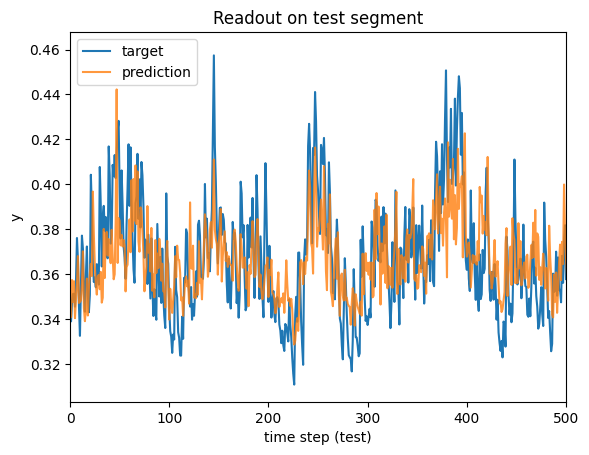

In [117]:
#@title Full run and readout
def run_lsm_and_readout(enc, g=1.2, tau_syn_ms=8.0, N=300, dt_ms=1.0, seed=42):
    u_used, y_used = enc["u_used"], enc["y_used"]
    G, sp_mon, st_mon, subset_idx = build_and_run_reservoir(
        u_used, enc["indices"], enc["times_ms"], enc["channels"],
        g=g, tau_m_ms=6.0, tau_syn_ms=tau_synapse,
        N=N, p_rec=0.1, p_in=0.30, exc_frac=0.8,
        w_in_scale=win, w_rec_scale=wrec, w_rec_exc_scale=wE, w_rec_inh_scale=wI,
        in_auto_scale=enc["auto_scale"],
        dt_ms=dt_ms, rng_seed=seed, record_sample=8, add_bg=False)

    Tsteps = len(u_used)
    X = np.zeros((Tsteps, len(G)))
    bin_edges = np.arange(0, Tsteps+1) * (dt_ms/1000.0)
    from brian2 import second
    for n in range(len(G)):
        times_n = sp_mon.t[sp_mon.i == n]/second
        if len(times_n) == 0:
            continue
        counts, _ = np.histogram(times_n, bins=bin_edges)
        X[:, n] = counts

    split = int(0.7*Tsteps)
    X_train, y_train = X[:split], y_used[:split]
    X_test,  y_test  = X[split:], y_used[split:]

    # --- Demean features (and optionally the target) ---
    mu_X = X_train.mean(axis=0)
    Xc_train = X_train - mu_X
    Xc_test  = X_test  - mu_X

    # (Optional but recommended) center y as well
    mu_y = y_train.mean()
    y_train_c = y_train - mu_y

    # Ridge *without* intercept (since we centered)
    alpha = 1.0  # try 10, 100 if predictions still too “large”
    model = Ridge(alpha=alpha, fit_intercept=False)
    model.fit(Xc_train, y_train_c)
    y_pred = model.predict(Xc_test) + mu_y

    mse = mean_squared_error(y_test, y_pred)
    nrmse = np.sqrt(mse) / (np.std(y_test) + 1e-8)

    idx = np.linspace(0, Tsteps-1, num=min(2000, Tsteps), dtype=int)
    X_sub = X[idx]
    if np.isclose(X_sub.var(axis=0).sum(), 0.0):
        PC = np.zeros((X_sub.shape[0], 2))
        evr = np.array([0.0, 0.0])
        print("PCA skipped: zero-variance states.")
    else:
        pca = PCA(n_components=2, random_state=seed)
        PC = pca.fit_transform(X_sub)
        evr = pca.explained_variance_ratio_[:2]

    dur_s = Tsteps * (dt_ms/1000.0)
    mean_rate_hz = sp_mon.num_spikes / (len(G) * dur_s)
    corr = np.corrcoef(y_test, y_pred)[0, 1]

    return {"corr": float(corr), "nrmse": float(nrmse), "y_test": y_test, "y_pred": y_pred,
            "X_sub_PC": PC, "evr": evr, "mean_rate_hz": mean_rate_hz, "split": split}

results = run_lsm_and_readout(enc, g=1.2, N=500, dt_ms=dt_ms, seed=123)

print(f"Correlation Coefficient: {results['corr']:.3f}")
print(f"NRMSE: {results['nrmse']:.3f} | mean rate: {results['mean_rate_hz']:.2f} Hz/neuron")
# if results["evr"].size == 2:
#     print(f"PCA explained variance: PC1={results['evr'][0]:.2%}, PC2={results['evr'][1]:.2%}")

plt.figure()
plt.plot(results["y_test"], label="target")
plt.plot(results["y_pred"], label="prediction", alpha=0.8)
plt.title("Readout on test segment")
plt.xlabel("time step (test)"); plt.ylabel("y")
plt.xlim(0, 500)
plt.legend(); plt.show()

# plt.figure()
# plt.plot(results["X_sub_PC"][:,0], results["X_sub_PC"][:,1], linewidth=0.5, alpha=0.7)
# plt.title("Reservoir state PCA trajectory (subsampled)")
# plt.xlabel("PC1"); plt.ylabel("PC2")
# plt.show()
